In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pysentani as sti
survey = pd.read_excel('../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx')
survey['access_type'] = sti.access_type(survey)

Average energy use will be calculated by appliance from use hours. The sum of the average appliance energy columns reflects average total energy use by all appliances. 

In [2]:
for app in ['TV', 'radio', 'fridge', 'fan', 'rice_cooker', 'lighting']:
    # generate column labels for each appliance
    wk_col = 'app_{}_per_wk'.format(app)
    hr_col = 'app_{}_hrs'.format(app)
    # if null or within range use value, otherwise use max possible value
    survey[hr_col] = survey[hr_col].where(survey[hr_col].isnull() | (survey[hr_col] <= 24), 24)
    survey[wk_col] = survey[wk_col].where(survey[wk_col].isnull() | (survey[wk_col] <= 7), 7)

    # ensure non-null values are within bounds
    assert(all(survey[wk_col].dropna() <= 7))
    assert(all(survey[wk_col].dropna() >= 0))
    assert(all(survey[hr_col].dropna() <= 24))
    assert(all(survey[hr_col].dropna() >= 0))

In [3]:
powers = {'TV':0.040, 'fridge':0.100, 'radio':0.010, 'fan':0.050, 'rice_cooker':0.350, 'lighting':0.050}
appliance_list = ['TV', 'fridge', 'radio', 'fan', 'rice_cooker', 'lighting']

for appliance in appliance_list:
    # create column label from appliance names
    wk_col = 'app_{}_per_wk'.format(appliance)
    hr_col = 'app_{}_hrs'.format(appliance)
    energy_col = 'daily_{}_energy'.format(appliance)
    weekly_hr_col = 'weekly_{}_hrs'.format(appliance)
    survey[weekly_hr_col] = survey[wk_col] * survey[hr_col]    
    survey[energy_col] = survey[weekly_hr_col] / 7 * powers[appliance]

Selecting only for energy columns created above.

In [4]:
columns = ['access_type',
           'village_name',
           'daily_lighting_energy',
           'daily_TV_energy',
           'daily_radio_energy', 
           'daily_fridge_energy', 
           'daily_rice_cooker_energy',
           'daily_fan_energy']


Filling null responses will ensure that energy use is calculated only if an appliance is owned and when we take the mean it will reflect the per household use for the entire village.

In [5]:
energy_data = survey[columns]
energy_data = energy_data.fillna(0)
energy_data.head()

,access_type,village_name,daily_lighting_energy,daily_TV_energy,daily_radio_energy,daily_fridge_energy,daily_rice_cooker_energy,daily_fan_energy
0,no_access,Puai,0.000000,0.160000,0.020000,0,0,0
1,no_access,Abar,0.042857,0.080000,0.008571,0,0,0
2,no_access,Abar,0.000000,0.120000,0.000000,0,0,0
3,no_access,Abar,0.114286,0.022857,0.000000,0,0,0
4,no_access,Abar,0.300000,0.000000,0.000000,0,0,0


Grouping energy columns by each village and their respective access type. I reset the index to get the data frame into a graph friendly format.

In [6]:
village_energy = energy_data.groupby(['village_name','access_type']).mean().reset_index()
village_energy.head()

,village_name,access_type,daily_lighting_energy,daily_TV_energy,daily_radio_energy,daily_fridge_energy,daily_rice_cooker_energy,daily_fan_energy
0,Abar,no_access,0.095031,0.067329,0.013913,0.015217,0.000000,0.002795
1,Ajau,PLN_grid,0.526531,0.141633,0.012041,0.440816,0.128571,0.000000
2,Asei,PLN_grid,0.439655,0.212808,0.003202,0.744828,1.227586,0.009606
3,Atamali,community_microgrid,0.261224,0.181224,0.016163,0.000000,0.154286,0.013265
4,Ayapo,PLN_microgrid,0.309583,0.129333,0.009214,0.018333,0.023333,0.006071


Creating total average daily energy column by taking the sum of appliance daily energy averages.

In [7]:
village_energy['Avg_Daily_Energy'] = village_energy.sum(axis=1)
village_energy.head()

,village_name,access_type,daily_lighting_energy,daily_TV_energy,daily_radio_energy,daily_fridge_energy,daily_rice_cooker_energy,daily_fan_energy,Avg_Daily_Energy
0,Abar,no_access,0.095031,0.067329,0.013913,0.015217,0.000000,0.002795,0.194286
1,Ajau,PLN_grid,0.526531,0.141633,0.012041,0.440816,0.128571,0.000000,1.249592
2,Asei,PLN_grid,0.439655,0.212808,0.003202,0.744828,1.227586,0.009606,2.637685
3,Atamali,community_microgrid,0.261224,0.181224,0.016163,0.000000,0.154286,0.013265,0.626163
4,Ayapo,PLN_microgrid,0.309583,0.129333,0.009214,0.018333,0.023333,0.006071,0.495869


Isolating only relevant columns that I am interested in graphing.

In [8]:
village_energy_sum = village_energy[['Avg_Daily_Energy','village_name','access_type']]
village_energy_sum.head()

,Avg_Daily_Energy,village_name,access_type
0,0.194286,Abar,no_access
1,1.249592,Ajau,PLN_grid
2,2.637685,Asei,PLN_grid
3,0.626163,Atamali,community_microgrid
4,0.495869,Ayapo,PLN_microgrid


Cleaning up column names.

In [9]:
village_energy_sum.replace(to_replace = {'village_name': {'Kampung_Baru': 'Kampung Baru',
                                           'Pantai_Yahim': 'Pantai Yahim'}},inplace = True)

village_energy_sum.replace(to_replace = {'access_type': {'PLN_grid': 'PLN Grid',
                                             'community_microgrid': 'Community Microgrid',
                                             'PLN_microgrid': 'PLN Microgrid',
                                             'no_access': 'Non-Centralized'}},inplace = True)

/Users/Matt/miniconda3/envs/mrenv/lib/python3.4/site-packages/pandas/core/generic.py:2790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [10]:
village_energy_sum.head()

,Avg_Daily_Energy,village_name,access_type
0,0.194286,Abar,Non-Centralized
1,1.249592,Ajau,PLN Grid
2,2.637685,Asei,PLN Grid
3,0.626163,Atamali,Community Microgrid
4,0.495869,Ayapo,PLN Microgrid


Seaborn Bar Plot

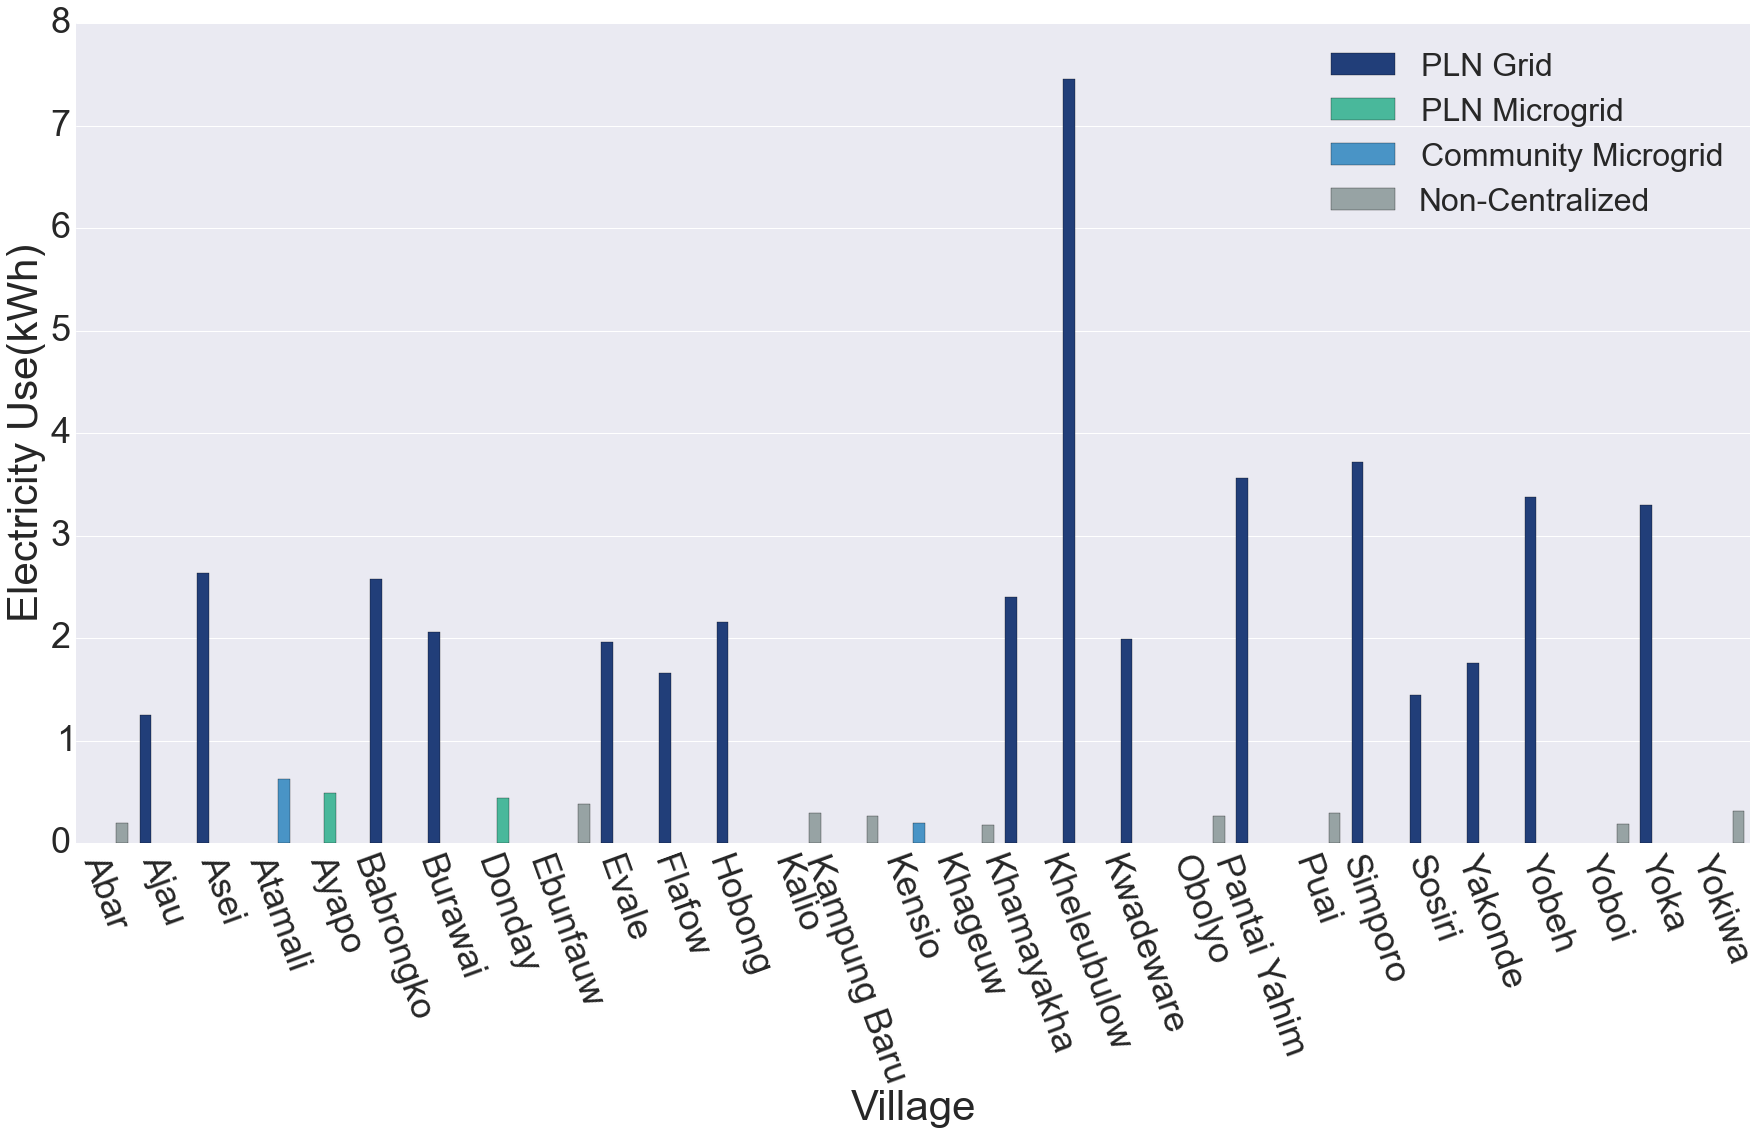

In [11]:
plt.figure(figsize=(30,17))
custom = ["#133987","#36CBA4", "#3498db", "#95a5a6"]
sns.barplot(x='village_name', y='Avg_Daily_Energy',hue='access_type',
            data=village_energy_sum,palette= custom,hue_order=['PLN Grid','PLN Microgrid',
            'Community Microgrid','Non-Centralized'])
plt.ylabel('Electricity Use(kWh)', fontsize=42)
plt.xlabel('Village', fontsize=42)
plt.xticks(rotation=-70)
plt.tick_params(labelsize=36)
plt.legend(prop={'size':32})
plt.gcf().subplots_adjust(bottom=0.23)
plt.savefig('daily-village-energy.png')

Metered Data (for reference only)

In [12]:
metered_locations = village_energy_sum[village_energy_sum['village_name'].str.contains('Ajau|Asei|Atamali|Ayapo|Kensio')]
metered_locations

,Avg_Daily_Energy,village_name,access_type
1,1.249592,Ajau,PLN Grid
2,2.637685,Asei,PLN Grid
3,0.626163,Atamali,Community Microgrid
4,0.495869,Ayapo,PLN Microgrid
14,0.201654,Kensio,Community Microgrid


Inputing interpreted point values from dsoto time series analysis. 

In [13]:
time_series_daily_point_estimates = pd.Series({'Ajau':6, 'Asei':5.6, 'Atamali':0.63, 'Ayapo':0.83,'Kensio':0.63})
time_series_daily_point_estimates

Ajau       6.00
Asei       5.60
Atamali    0.63
Ayapo      0.83
Kensio     0.63
dtype: float64